**Modelo de red neuronal Transformer**

Este archivo consta de los codigos y conclusiones de:
* 1.Carga de librerias y datos
* 2.Normalizar Datos.
* 3.Preparar datos para realizar aprendizaje supervizado.
* 4.Modelo Transformer
* 5.Evaluacion del modelo


#1.Carga de Librerias y Datos


*Se importan los módulos necesarios para trabajar*

In [19]:
#Pandas es utilizado para leer los set de datos
import pandas as pd
#Numpy es utilizado para generar las series de datos a graficar
import numpy as np
#Seaborn es utilizado para generar los gráficos
import seaborn as sns
import matplotlib.pyplot as plt
#Se importan modulos estadisticos para generar test de hipotesis, entre otros
from sklearn.preprocessing import StandardScaler,MinMaxScaler
#Módulos implementa funciones que evalúan el error de predicción para propósitos específicos
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse

#Dividir arreglos o matrices en subconjuntos aleatorios de tren y prueba
from sklearn.model_selection import train_test_split

#Biblioteca de Redes Neuronales
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,model_from_json
from keras.layers import Dropout, LSTM, Dense, Activation,Input
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

from hyperopt import Trials, STATUS_OK, tpe, hp, fmin, space_eval
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, TimeSeriesSplit
import time


In [20]:
pip install h5py --quiet

In [21]:
import os

In [22]:
# Para acceder a los archivos del gdrive
from google.colab import drive
drive.mount('/content/gdrive/')


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [23]:
cd /content/gdrive/MyDrive/Tesis/Datos-2

/content/gdrive/MyDrive/Tesis/Datos-2


Se obtiene conjunto de datos

In [24]:
predictor_variables=pd.read_csv('predictor_variables.csv', index_col='dt')
target_variables=pd.read_csv('target_variables.csv', index_col='dt')
df=pd.read_csv('df_modelo.csv', index_col='dt')

#Exportar resultados

In [25]:
result_LSTM=pd.read_csv('results_LSTM_CE.csv')
result_LSTM_order=result_LSTM.copy()
result_LSTM_order = result_LSTM_order.sort_values(by='MSE', ascending=True)
result_LSTM_order.head(5)

,Unnamed: 0,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
139,139,LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576...,28,5,36.681360,0.378168,0.614954,0.455236,220.871017
319,319,LSTM_CE_800_10.0_1.0_640.0_0.42_adam_4.4268419...,64,5,28.392772,0.379389,0.615946,0.456227,220.155869
299,299,LSTM_CE_800_20.0_1.0_780.0_0.68_adam_4.2855902...,60,5,23.493317,0.380622,0.616946,0.457438,223.087753
94,94,LSTM_CE_800_30.0_1.0_620.0_0.55_adam_3.4341560...,19,5,20.831620,0.380932,0.617197,0.456960,224.679672
499,499,LSTM_CE_800_20.0_2.0_480.0_0.54_adam_1.6602774...,100,5,51.668610,0.380971,0.617228,0.457549,221.807846


In [26]:
nombre_archivo=result_LSTM_order['nameModel'].iloc[0]
nombre_archivo

'LSTM_CE_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05'

In [27]:
nombre_archivo="LSTM_CE_28_5_800_10.0_1.0_680.0_0.52_adam_3.1458576754462924e-05"

In [28]:
nombre_json=nombre_archivo+"."+"json"
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/result_LSTM'
ruta = os.path.join(carpeta_destino, nombre_json)
save_w=nombre_archivo+"."+"h5"
weights_path = os.path.join(carpeta_destino, save_w)

In [29]:
# load json and create model
json_file = open(ruta, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(weights_path)
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=3.1458576754462924e-05), metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()])


Loaded model from disk


# Generar Narmax data


In [30]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
predictor=np.array(predictor_variables)
predictor= predictor.reshape((predictor_variables.shape[0], 1, predictor_variables.shape[1]))
shape_target=target_variables.shape

In [31]:
def narmax_data(data,modelo,predictor,shape_target,retrasos):
  #Se realiza prediccion
  results = modelo.predict(predictor)
  results = results.reshape(shape_target)
  target=np.array(target_variables)
  error=[]
  aux=0
  for prediccion, real in zip(results,target):
    aux=real-prediccion
    error.append(aux[0])

  df_narmax = data.iloc[retrasos:]
  # Agregamos el arreglo como nueva columna en el DataFrame
  df_narmax['error'] = error

  return df_narmax

In [32]:
df=narmax_data(df,loaded_model,predictor,shape_target,3)
df

45/45 [==============================] - 5s 2ms/step


<ipython-input-31-2b069516e065>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_narmax['error'] = error


,Global_active_power,Global_intensity,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,error
dt,,,,,,,,
2006-12-19,0.165544,0.181727,-0.526763,0.566945,-0.478415,2.753617,-0.799143,-1.254925
2006-12-20,1.085635,1.062706,-0.327783,0.717836,-1.006562,0.380121,1.263615,0.510655
2006-12-21,0.249270,0.239930,-0.660841,0.099227,0.104498,0.368143,0.308547,-0.446387
2006-12-22,1.275703,1.294563,0.184862,0.168754,0.976980,-0.720867,0.494736,0.969582
2006-12-23,5.274789,5.385178,0.868785,-0.343654,0.673563,-0.684934,1.437479,4.181917
...,...,...,...,...,...,...,...,...
2010-11-22,0.782730,0.803613,-0.696695,-0.313822,2.049641,0.122362,0.233810,0.980422
2010-11-23,0.019761,0.037690,-0.793731,-0.128886,0.171225,-0.669123,-0.428340,-0.725866
2010-11-24,0.379396,0.366498,-0.892469,-0.395024,-0.316634,0.475942,0.781361,0.297169


#3.Preparar datos para realizar aprendizaje supervizado.

La idea es modelar cada valor en función de los valores recientes anteriores, dado un retardo de tiempo dado. **Los valores futuros de una variable en una serie de tiempo dependen de sus propios rezagos y de los rezagos de otras variables.**

In [33]:
def time_delay_embedding(series: pd.Series, n_lags: int, horizon: int):
    """
    Incrustación de retardo de tiempo
    :param series: serie de tiempo como objeto de pandas
    :param n_lags: número de valores pasados para usar como variables explicativas
    :param horizon: horizonte de pronostico
    :return:pd.DataFrame con series temporales reconstruidas
    """
    assert isinstance(series, pd.Series)

    if series.name is None:
        name = 'Series'
    else:
        name = series.name

    n_lags_iter = list(range(n_lags, -horizon, -1))

    serie_time_delay = [series.shift(i) for i in n_lags_iter]
    serie_time_delay = pd.concat(serie_time_delay, axis=1).dropna()
    serie_time_delay.columns = [f'{name}(t-{j - 1})'
                 if j > 0 else f'{name}(t+{np.abs(j) + 1})'
                 for j in n_lags_iter]

    return serie_time_delay

In [34]:
serie_split = []
for columna in df:
  col_df = time_delay_embedding(
      df[columna], #Serie de tiempo
      n_lags=3, #Numero de retrasos
      horizon=1 # Horizonte de prediccion
      )
  serie_split.append(col_df)

In [35]:
serie_df = pd.concat(serie_split, axis=1).dropna()

In [36]:
predictor_variables = serie_df.columns.str.contains('\(t\-')
target_variables = serie_df.columns.str.contains('Global_active_power\(t\+')

In [37]:
predictor_variables = serie_df.iloc[:, predictor_variables]
target_variables = serie_df.iloc[:, target_variables]

In [38]:
#Se separa conjunto en entrenamiento y prueba; sin aleatoriedad
#Dejando un %30 de la data para test
X_train, X_test, Y_train, Y_test = train_test_split(predictor_variables, target_variables, test_size=0.2, shuffle=False)

shape_x_test=X_test.shape
shape_y_test=Y_test.shape

print("Separacion de datos terminada!")

Separacion de datos terminada!


In [39]:
#Se da formato de entradas como: Un tensor 3D con la forma [batch, timesteps, feature]
X_train=np.array(X_train)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

Y_train_s=np.array(Y_train)
Y_train_s = Y_train_s.reshape((Y_train_s.shape[0], 1, Y_train_s.shape[1]))

X_test=np.array(X_test)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

Y_test=np.array(Y_test)
Y_test = Y_test.reshape((Y_test.shape[0], 1, Y_test.shape[1]))

#5.LSTM

In [40]:
# Ajustar parámetros para reproducibilidad del entrenamiento
#tf.random.set_seed(123)
keras.utils.set_random_seed(123)
tf.config.experimental.enable_op_determinism()

In [41]:
# Función para crear el modelo LSTM
def create_model(neurons, dropout,layers,learning_rate):

    #Creacion de la arquitectura LSTM
    model = Sequential()
    #Capas ocultas
    for i in range(layers):
        model.add(LSTM(units=neurons, return_sequences=(layers-1), activation='tanh', input_shape=(X_train.shape[1],X_train.shape[2])))
        model.add(Dropout(dropout))
    #Capa de salida
    model.add(Dense(1))

    #Se configura el proceso de entrenamiento del modelo y metricas de evaluacion
    model.compile(loss='mean_squared_error',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics = [tf.keras.metrics.MeanSquaredError(),
                            tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),
                            tf.keras.metrics.MeanAbsolutePercentageError()]
                  )
    return model

In [42]:
def objective(params):
    # Definir los hiperparámetros a optimizar
    epochs = params['epochs']
    batch_size = params['batch_size']
    optimizer = params['optimizer']
    neurons  = params['neurons']
    dropout  = params['dropout']
    layers  = params['layers']
    learning_rate = params['learning_rate']

    # Crear el modelo de LSTM


    #kf = KFold(n_splits=5)
    tscv = TimeSeriesSplit(n_splits=5)
    scores = []
    times=[]
    models=[]
    scores_test=[]

    #Se detiene el entrenamiento en el momento que se observe un incremento en el valor del error de validación.
    early_stop = EarlyStopping(monitor='val_loss', patience=30, mode='min',restore_best_weights=True)

    #Validacion cruzada
    for train_index, test_index in tscv.split(X_train):
      X_train_, X_test_ = X_train[train_index], X_train[test_index]
      y_train_, y_test_ = Y_train_s[train_index], Y_train_s[test_index]

      model = create_model(int(neurons), float(dropout),int(layers),float(learning_rate))
      #Entrenamiento
      start = time.time()
      hist=model.fit(X_train_, y_train_, batch_size=int(batch_size), epochs=int(epochs), verbose=0, validation_data=(X_test_, y_test_),callbacks=[early_stop],use_multiprocessing=True)
      end = time.time()

      #Evaluacion del modelo
      score = model.evaluate(X_test_, y_test_, verbose = 0)
      scores.append(score)
      #Error en conjunto de test
      score_test = model.evaluate(X_test, Y_test, verbose = 0)
      scores_test.append(score_test)

      #guardar modelo keras
      models.append(model)

      #Tiempo de la validadion cruzada
      time_val= end- start
      times.append(time_val)

    return {'loss': np.mean(scores),
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'time':times,
            'hist':hist,
            'scores_test': scores_test,
            'scores': scores,
            'models':models}

In [43]:
'''
#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size':  hp.quniform('batch_size', 10, 100, 10),
    'optimizer':'adam',
    'neurons': hp.quniform('neurons', 100, 800, 20),
    'dropout':hp.uniform('dropout', 0.4, 0.7),
    'layers': hp.quniform('layers', 1, 3, 1),
    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005)
}
'''

"\n#Se define el espacio de busqueda de hiperparametros para el modelo\nspace = {\n    'epochs': 800,\n    'batch_size':  hp.quniform('batch_size', 10, 100, 10),\n    'optimizer':'adam',\n    'neurons': hp.quniform('neurons', 100, 800, 20),\n    'dropout':hp.uniform('dropout', 0.4, 0.7),\n    'layers': hp.quniform('layers', 1, 3, 1),\n    'learning_rate': hp.uniform('learning_rate', 0.00001, 0.00005)\n}\n"

In [44]:

#Se define el espacio de busqueda de hiperparametros para el modelo
space = {
    'epochs': 800,
    'batch_size': 90,
    'optimizer':'adam',
    'neurons': 100,
    'dropout':0.6859305333913882,
    'layers': 1,
    'learning_rate': 1.0092243575868021e-05
}


In [45]:
trials = Trials()
#Optimización bayesiana
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=1, trials=trials)
print("Modelo entrenado 1!")

100%|██████████| 1/1 [04:06<00:00, 246.03s/trial, best loss: 56.591456763744354]
Modelo entrenado 1!


In [46]:
#Obtener el valor de la función objetivo del mejor ensayo
best_trial = trials.best_trial
hist = best_trial['result']['hist']
best_model = best_trial['result']['model']
scores_model = best_trial['result']['scores_test']

In [47]:
# Obtener una lista de los resultados de todas las evaluaciones
all_results = [trial['result'] for trial in trials]

In [48]:
# Mejores hiperparámetros encontrados
best_params = space_eval(space, best)
best_params

{'batch_size': 90,
 'dropout': 0.6859305333913882,
 'epochs': 800,
 'layers': 1,
 'learning_rate': 1.0092243575868021e-05,
 'neurons': 100,
 'optimizer': 'adam'}

In [49]:
#Metricas de precision del modelo keras
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3622264266014099
RMSE: 0.6018524765968323
MAE: 0.4484776258468628
MAPE: 420.7680358886719


# 6.Evaluacion del modelo

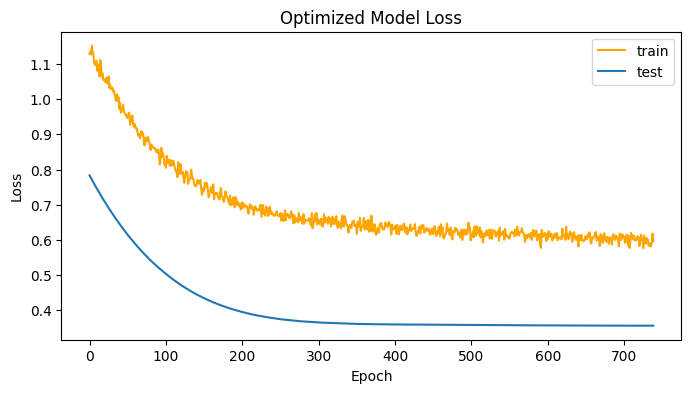

In [50]:
plt.figure(figsize=(8,4))
plt.plot(hist.history['loss'], color = 'orange')
plt.plot(hist.history['val_loss'])
plt.title('Optimized Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [51]:
#Se realiza prediccion
results = best_model.predict(X_test)

9/9 [==============================] - 0s 2ms/step


In [52]:
results = results.reshape(shape_y_test)
y_grafico = Y_test.reshape(shape_y_test)

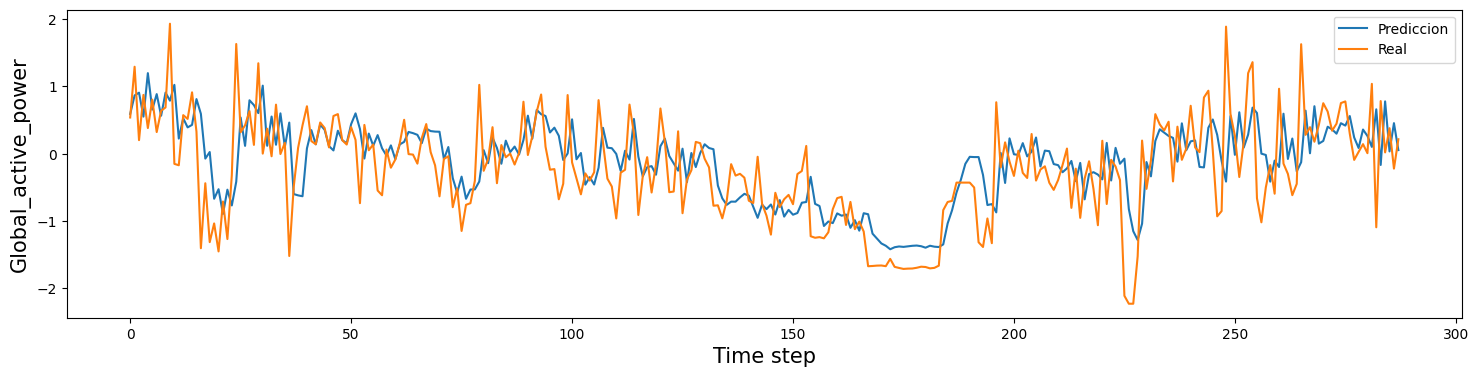

In [53]:
#Grafico de prediccion con el valor real
tiempo=[x for x in range(y_grafico.shape[0])]
plt.figure(figsize=(18,4))
plt.plot(tiempo,results)
plt.ylabel('Global_active_power', size=15)
plt.plot(tiempo,y_grafico)
plt.xlabel('Time step', size=15)
plt.legend(['Prediccion','Real'])
plt.show()

In [54]:
#Metricas de precision del modelo
score = best_model.evaluate(X_test, Y_test, verbose = 0)
print('MSE:', score[1])
print('RMSE:', score[2])
print('MAE:', score[3])
print('MAPE:', score[4])

MSE: 0.3622264266014099
RMSE: 0.6018524765968323
MAE: 0.4484776258468628
MAPE: 420.7680358886719


#Exportar resultados

Se guardan los resultados la optimizacion bayesiana

In [55]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los parametros para exportalos a un csv
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for time in result['time']:
    k+=1
    nameModel = "LSTM_CE" + "_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    results.append([nameModel,trial,k,time,
                    result['scores_test'][i][0],result['scores_test'][i][2],result['scores_test'][i][3],result['scores_test'][i][4]]
                   )
    i+=1

In [56]:
#Se crea dataframe
results_csv=pd.DataFrame(results,columns=['nameModel','trial_optimizacion_bayesiana','Step_validacion','time','MSE','RMSE','MAE','MAPE'])

In [57]:
results_o = results_csv.sort_values(by='MSE', ascending=True)
results_o.head(5)

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
4,LSTM_CE_1_5_800_90_1_100_0.69_adam_1.009224357...,1,5,60.136909,0.362226,0.601852,0.448478,420.768036
3,LSTM_CE_1_4_800_90_1_100_0.69_adam_1.009224357...,1,4,34.146364,0.381413,0.617586,0.466746,416.832397
1,LSTM_CE_1_2_800_90_1_100_0.69_adam_1.009224357...,1,2,48.999762,0.405976,0.637163,0.484218,431.966858
2,LSTM_CE_1_3_800_90_1_100_0.69_adam_1.009224357...,1,3,55.191955,0.422390,0.649916,0.492361,520.818359
0,LSTM_CE_1_1_800_90_1_100_0.69_adam_1.009224357...,1,1,45.439553,0.444992,0.667077,0.516479,264.664093


In [58]:
results_o

,nameModel,trial_optimizacion_bayesiana,Step_validacion,time,MSE,RMSE,MAE,MAPE
4,LSTM_CE_1_5_800_90_1_100_0.69_adam_1.009224357...,1,5,60.136909,0.362226,0.601852,0.448478,420.768036
3,LSTM_CE_1_4_800_90_1_100_0.69_adam_1.009224357...,1,4,34.146364,0.381413,0.617586,0.466746,416.832397
1,LSTM_CE_1_2_800_90_1_100_0.69_adam_1.009224357...,1,2,48.999762,0.405976,0.637163,0.484218,431.966858
2,LSTM_CE_1_3_800_90_1_100_0.69_adam_1.009224357...,1,3,55.191955,0.422390,0.649916,0.492361,520.818359
0,LSTM_CE_1_1_800_90_1_100_0.69_adam_1.009224357...,1,1,45.439553,0.444992,0.667077,0.516479,264.664093


In [59]:
# Exportar el DataFrame como CSV
results_csv.to_csv('Narmax_results_LSTM_CE.csv')

Se guarda cada modelo keras en un objeto Json

In [60]:
import os
# Ruta de la carpeta que deseas crear
carpeta_destino = '/content/gdrive/MyDrive/Tesis/Datos-2/Narmax_result_lstm'

# Verificar si la carpeta ya existe
if not os.path.exists(carpeta_destino):
    # Crear la carpeta si no existe
    os.makedirs(carpeta_destino)

In [62]:
#Del objeto all_results donde estan los resultados de cada trial de la optimizacion bayesiana se obtiene los modelos para exportalos a un Json
results=[]
trial=0 #Nº de intento de optimizacion bayesiana

for result in all_results:
  k=0 #validacion cruzada
  trial+=1
  i=0
  for model in result['models']:
    k+=1
    nameModel = "LSTM_CE"+"_"+str(trial)+"_"+str(k) + "_"+str(result['params']['epochs'])+"_"+str(result['params']['batch_size'])+"_"+str(result['params']['layers'])+"_"+str(result['params']['neurons'])+"_"+str(round(result['params']['dropout'],2))+"_"+str(result['params']['optimizer'])+"_"+str(result['params']['learning_rate'])
    model_json = model.to_json()
    ruta = os.path.join(carpeta_destino, nameModel + ".json")
    with open(ruta, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    save_w=nameModel+"."+"h5"
    weights_path = os.path.join(carpeta_destino, save_w)
    model.save_weights(weights_path)
    i+=1